In [1]:
pip install opencv-python numpy csv

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [1]:
!pip install opencv-contrib-python --upgrade --force-reinstall

  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (69.1 MB)
Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.11.0.86
    Uninstalling opencv-contrib-python-4.11.0.86:
      Successfully uninstalled opencv-contrib-python-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires n

In [3]:
import cv2
print(cv2.__version__)
print(dir(cv2.face))    #should list LBPHFaceRecognizer_create

4.10.0
['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']



1. Register Face
2. Recognize Faces
3. Exit
Choose an option (1/2/3): 2


<IPython.core.display.Javascript object>

hasan already marked attendance today.


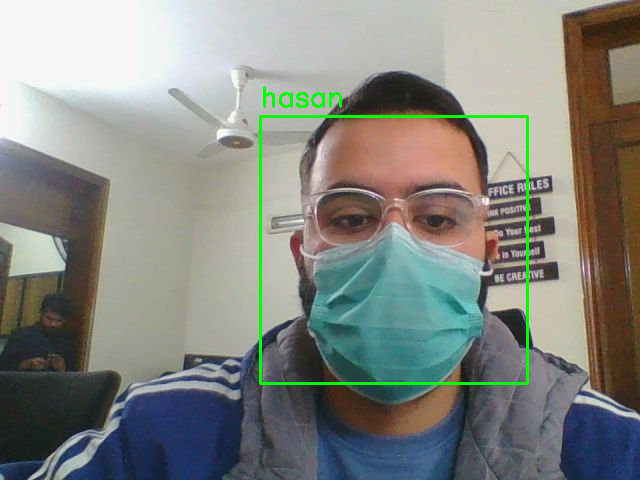

Press 'q' to quit or any key to continue: q

1. Register Face
2. Recognize Faces
3. Exit
Choose an option (1/2/3): 2


<IPython.core.display.Javascript object>

Attendance logged for hasan at 13:16:24


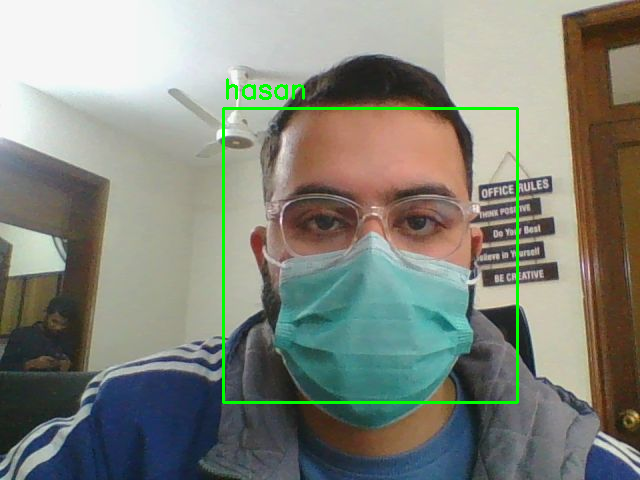

Press 'q' to quit or any key to continue: q

1. Register Face
2. Recognize Faces
3. Exit
Choose an option (1/2/3): 3


In [20]:
import cv2
import numpy as np
import os
import csv
from datetime import datetime
import pytz
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode

# ----------
# Webcam Setup (Colab-specific)
# ----------
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# ----------
# Face Recognition Setup
# ----------
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

dataset_dir = "dataset"
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

registered_names = []
if os.path.exists("registered_names.npy"):
    registered_names = np.load("registered_names.npy", allow_pickle=True).tolist()

# ----------
# Register Face
# ----------
def register_face():
    name = input("Enter your name: ").strip()
    if name in registered_names:
        print(f"{name} is already registered!")
        return

    face_samples = []
    for _ in range(5):  #capture number of times
        filename = take_photo()
        image = cv2.imread(filename)
        if image is None:
            print("Failed to capture image. Try again.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) == 0:
            print("No face detected. Try again.")
            os.remove(filename)
            continue

        (x, y, w, h) = faces[0]
        face_roi = gray[y:y+h, x:x+w]
        face_samples.append(face_roi)
        os.remove(filename)  #cleanup

    if not face_samples:
        print("Failed to register. No valid face samples.")
        return

    #save data
    registered_names.append(name)
    np.save("registered_names.npy", registered_names)
    for idx, face in enumerate(face_samples):
        cv2.imwrite(f"{dataset_dir}/{name}_{idx}.jpg", face)

    train_model()
    print(f"{name} registered successfully!")

# ----------
# Train Model
# ----------
def train_model():
    faces = []
    labels = []
    for label, name in enumerate(registered_names):
        for img_file in os.listdir(dataset_dir):
            if img_file.startswith(name):
                img_path = os.path.join(dataset_dir, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                faces.append(img)
                labels.append(label)

    if faces:
        face_recognizer.train(faces, np.array(labels))
        face_recognizer.save("trained_model.yml")
        print("Model trained!")

# ----------
# Recognize Faces (Colab-compatible)
# ----------
def recognize_faces():
    if not os.path.exists("trained_model.yml"):
        print("No trained model found. Register a face first!")
        return

    face_recognizer.read("trained_model.yml")
    while True:
        filename = take_photo()
        image = cv2.imread(filename)
        if image is None:
            print("Failed to capture image. Try again.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in faces:
            face_roi = gray[y:y+h, x:x+w]
            label, confidence = face_recognizer.predict(face_roi)
            name = registered_names[label] if confidence < 60 else "Unknown"

            if name != "Unknown":
                log_attendance(name)

            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(image, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


        cv2_imshow(image)
        os.remove(filename)  #cleanup captured photo

        #exit
        if input("Press 'q' to quit or any key to continue: ").strip().lower() == 'q':
            break

# ----------
# Attendance Logging with Correct Local Time
# ----------
def log_attendance(name):
    #local timezone
    local_timezone = pytz.timezone('Asia/Karachi')
    now = datetime.now(local_timezone)
    date_str = now.strftime("%Y-%m-%d")
    time_str = now.strftime("%H:%M:%S")

    #check if attendance already logged today
    if os.path.exists("attendance.csv"):
        with open("attendance.csv", "r") as file:
            reader = csv.reader(file)
            for row in reader:
                if row[0] == name and row[1] == date_str:
                    print(f"{name} already marked attendance today.")
                    return

    # Log attendance
    with open("attendance.csv", "a") as file:
        writer = csv.writer(file)
        writer.writerow([name, date_str, time_str])
    print(f"Attendance logged for {name} at {time_str}")

# ----------
# Main Program
# ----------
if __name__ == "__main__":
    while True:
        print("\n1. Register Face\n2. Recognize Faces\n3. Exit")
        choice = input("Choose an option (1/2/3): ").strip()

        if choice == '1':
            register_face()
        elif choice == '2':
            recognize_faces()
        elif choice == '3':
            break
        else:
            print("Invalid choice!")